## License 

Copyright 2019 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

# Model Debugging by Sensitivity Analysis

Sensitivy analysis, or analyzing perturbations of input data under a trained model, is a straightfoward method to assess accuracy, fairness, feature importance, security, and stability in machine learning. This notebook will focus on using sensitivity analysis to discover error mechanisms and security vulnerabilities and to assess stability in a trained XGBoost model. This notebook will begin by loading the UCI credit card default data and then training an interpretable, monotonically constrained XGBoost gradient boosting machine (GBM) model. (Pearson correlation with the prediction target is used to determine the direction of the monotonicity constraints for each input variable.) After the model is trained global and local Shapley feature importance is calculated. These Shapley values help inform the application of partial dependence and ICE and a search for adversarial examples. The notebook closes by exposing the trained model to a _random attack_ and analyzing the attack results.

#### Python imports 

In [1]:
import numpy as np                        # array, vector, matrix calculations
import os                                 # file-handling
import pandas as pd                       # DataFrame handling
import shap                               # for consistent, signed variable importance measurements
import xgboost as xgb                     # gradient boosting machines (GBMs)

from itertools import combinations        # n choose k combinations of objects
import string                             # for operations on character strings

pd.options.display.max_columns = 999      # enable display of all dataframe columns in notebook

import matplotlib.pyplot as plt           # general plotting utilities
from mpl_toolkits.mplot3d import Axes3D   # for 3-D projections
from matplotlib import cm                 # colormaps for plots

# enables display of plots in notebook
%matplotlib inline

np.random.seed(12345)                     # set random seed for global scope

## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`. 

In [2]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [3]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`-`PAY_6`, and the prediction target `DEFAULT_NEXT_MONTH`, are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [4]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 2. Investigate pair-wise Pearson correlations for DEFAULT_NEXT_MONTH

Monotonic relationships are much easier to explain to colleagues, bosses, customers, and regulators than more complex, non-monotonic relationships and monotonic relationships may also prevent overfitting and excess error due to variance for new data.

To train a transparent monotonic classifier, contraints must be supplied to XGBoost that determine whether the learned relationship between an input variable and the prediction target `DEFAULT_NEXT_MONTH` will be increasing for increases in an input variable or decreasing for increases in an input variable. Pearson correlation provides a linear measure of the direction of the relationship between each input variable and the target. If the pair-wise Pearson correlation between an input and `DEFAULT_NEXT_MONTH` is positive, it will be constrained to have an increasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. If the pair-wise Pearson correlation is negative, the input will be constrained to have a decreasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. 

Constrainsts are supplied to XGBoost in the form of a Python tuple with length equal to the number of inputs. Each item in the tuple is associated with an input variable based on its index in the tuple. The first constraint in the tuple is associated with the first variable in the training data, the second constraint in the tuple is associated with the second variable in the training data, and so on. The constraints themselves take the form of a 1 for a positive relationship and a -1 for a negative relationship.

#### Calculate Pearson correlation

The Pandas `.corr()` function returns the pair-wise Pearson correlation between variables in a Pandas DataFrame. Because `DEFAULT_NEXT_MONTH` is the last column in the `data` DataFrame, the last column of the Pearson correlation matrix indicates the direction of the linear relationship between each input variable and the prediction target, `DEFAULT_NEXT_MONTH`. According to the calculated values, as a customer's balance limit (`LIMIT_BAL`), bill amounts (`BILL_AMT1`-`BILL_AMT6`), and payment amounts (`PAY_AMT1`-`PAY_AMT6`) increase, their probability of default tends to decrease. However as a customer's number of late payments increase (`PAY_0`, `PAY_2`-`PAY6`), their probability of default usually increases. In general, the Pearson correlation values make sense, and they will be used to ensure that the modeled relationships will make sense as well. (Pearson correlation values between the target variable, DEFAULT_NEXT_MONTH, and each input variable are displayed directly below.)

In [5]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1] 

,DEFAULT_NEXT_MONTH
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


#### Create tuple of monotonicity constraints from Pearson correlation values

The last column of the Pearson correlation matrix is transformed from a numeric column in a Pandas DataFrame into a Python tuple of `1`s and `-1`s that will be used to specifiy monotonicity constraints for each input variable in XGBoost. If the Pearson correlation between an input variable and `DEFAULT_NEXT_MONTH` is positive, a positive montonic relationship constraint is specified for that variable using `1`. If the correlation is negative, a negative monotonic constraint is specified using `-1`. (Specifying `0` indicates that no constraints should be used.) The resulting tuple will be passed to XGBoost when the GBM model is trained.

In [6]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

## 3. Train XGBoost with monotonicity constraints

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable, but here the `monotone_constraints` tuning parameter is used to enforce monotonicity between inputs and the prediction for `DEFAULT_NEXT_MONTH`. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, GBM variable importance is calculated and displayed. GBM variable importance is a global measure of the overall impact of an input variable on the GBM model predictions. Global variable importance values give an indication of the magnitude of a variable's contribution to model predictions for all observations. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

#### Split data into training and test sets for early stopping

The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [7]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.70    # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


#### Train XGBoost GBM classifier
To train an XGBoost classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. Many XGBoost tuning parameters must be specified as well. Typically a grid search would be performed to identify the best parameters for a given modeling task. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Notice that the monotonicity constraints are passed to XGBoost using the `monotone_constraints` parameter. Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test area under the curve (AUC) statistic fails to increase for 50 iterations.

In [8]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 12345                               # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      62,                       # shap currently does not account for early stopping, pre-determined
                      evals=watchlist,          # use watchlist for early stopping 
                      verbose_eval=True)        # display iteration progress


[0]	train-auc:0.763478	eval-auc:0.765509
[1]	train-auc:0.771212	eval-auc:0.768848
[2]	train-auc:0.771411	eval-auc:0.767005
[3]	train-auc:0.77285	eval-auc:0.76901
[4]	train-auc:0.773584	eval-auc:0.769504
[5]	train-auc:0.775445	eval-auc:0.77169
[6]	train-auc:0.775442	eval-auc:0.771476
[7]	train-auc:0.775416	eval-auc:0.771288
[8]	train-auc:0.775419	eval-auc:0.771343
[9]	train-auc:0.776108	eval-auc:0.771897
[10]	train-auc:0.777171	eval-auc:0.772864
[11]	train-auc:0.77744	eval-auc:0.77342
[12]	train-auc:0.777984	eval-auc:0.773897
[13]	train-auc:0.77807	eval-auc:0.7739
[14]	train-auc:0.778602	eval-auc:0.774412
[15]	train-auc:0.77884	eval-auc:0.774702
[16]	train-auc:0.779087	eval-auc:0.774935
[17]	train-auc:0.779952	eval-auc:0.77544
[18]	train-auc:0.780322	eval-auc:0.775555
[19]	train-auc:0.780836	eval-auc:0.775873
[20]	train-auc:0.781414	eval-auc:0.776262
[21]	train-auc:0.781846	eval-auc:0.776611
[22]	train-auc:0.7821	eval-auc:0.776686
[23]	train-auc:0.782496	eval-auc:0.777071
[24]	train-auc

#### Global Shapley variable importance
By setting `pred_contribs=True`, XGBoost's `predict()` function will return Shapley values for each row of the test set. Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be ploted below to get a more holistic and consisent measurement for the global importance of each input variable. Shapley values are an old idea, originally from the 1950s. A more recent innovation called _Tree SHAP_ made them more efficient for use in everyday data mining tasks: https://arxiv.org/pdf/1802.03888.pdf. 

#### Calculate Shapley values using Tree SHAP

In [9]:
# dtest is DMatrix
# shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True, ntree_limit=xgb_model.best_ntree_limit)

#### Display Shapley values for each input variable

/Users/phall/anaconda/lib/python3.5/site-packages/shap/plots.py:293: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  features = features.as_matrix()


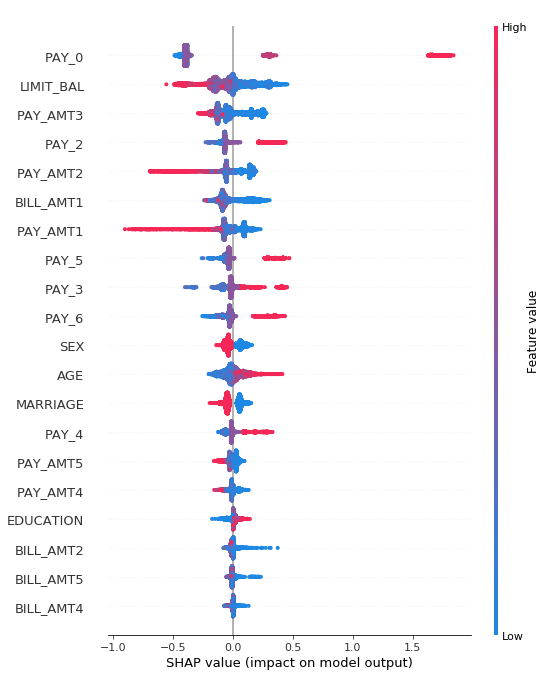

In [10]:
# drop last column of Shapley value array, which is constant intercept
# safest to use xgb_model.feature_names, seems to gaurantee consistent order
shap.summary_plot(shap_values[:, :-1], test[xgb_model.feature_names])

From the Shapley summary plot, we can see that `PAY_0`, or a customer's most recent repayment status, exerts a large influence on the model. High values of `PAY_0` are associated with large positive local contributions to model predictions. Low `PAY_0` values are associated with large negative local contributions to model predictions. `PAY_3`, or a customer's third most recent repayment status also seems to have a similar, but less intense, effect on the model predictions. Whereas, `PAY_AMT1` and `PAY_AMT2`, a customer most and second-most recent payment amounts, display large negative local feature contributions. We will look into the effects of these variables below.

#### Function for calculating partial dependence, its residuals, and ICE
In addition to calculating partial dependence, the residuals of partial dependence can also be indicative of model error mechanisms in some cases. The function here can calculate partial dependence, it's residuals, and ICE.

# 4. Partial Dependence for Model Debugging

Standard approaches for partial dependence and ICE are discussed at length in another notebook in this series: https://github.com/jphall663/interpretable_machine_learning_with_python/blob/master/xgboost_pdp_ice.ipynb. In general partial dependence is used to understand the average predictions of a model across the domain of one or more input variable(s). This alone is very helpful information from a model debugging perspective. A user can see generally when a model is making high predictions and low predictions and if this prediction behavior makes sense from a predictive accuracy standpoint. You can also begin to understand the sensitivity of a model to any given input variable. If partial dependence swings widely across the domain of a given variable, the model predictions are likely sensitive to the values of this variable and this variable would be expected to have high importance in the model. 

Even if the model predictions are suitably accurate, being highly sensitive to the values of an input variable can present disparate impact, security, and stability problems. If a model's average predictions, as illustrated by partial dependence, are different across different races, genders, disability statuses, or other demographic segments this is likely cause for a deeper analysis into the observational fairness of the model's prediction behavior, such as a disparate impact analysis: https://github.com/jphall663/interpretable_machine_learning_with_python/blob/master/dia.ipynb.  Being highly sensitive to the values of any one input variable is also worrisome due to model drift and the ease with which an adversary could game the model predictions. Once a model is deployed, it's input variable values will likely drift as the real-world environment changes. Partial dependence can show us approximately how a model may react when drift occurs. If the model's simulated drift behavior is problematic, these drift patterns should be monitored closely after the model is deployed. The steps below will calculate partial dependence and ICE on missing values and high-out-range values to test a model's performance on unseen data. The steps below will calculate partial dependence and ICE on missing values and high-out-range values to test a model's performance on unseen data. Partial dependence can also be determined from public predition APIs. A malicious actor can potentially see the same partial dependence plots as the model developers and use this information to construct adversarial examples to ensure they recieve the prediction they want from the model. Adversarial examples are discussed further in Section 5. 

If a variable's partial dependence curve is mostly flat the model should not be very sensitive to changes in the value of the variable and this variable would be expected to have low importance. If your model is placing high importance on a variable with a flat partial dependence curve, this could indicate a problem with your model training process or the variable in question could be part of a group of strongly correlated variables or variables with strong interactions. ICE will be used to help increase the trustworthiness of partial dependence in the steps below. If the average global behavior of partial dependence is representative of the individual ICE curves, the partial dependence is likely trustworthy. If ICE curves diverge from partial dependence curves, this is an indication of strong correlation or interactions in the model training data which can cause accuracy problems in many cases. ICE also clues users into any local disparate impact, drift, or security problems. ICE can also show if certain regions of the model's response function are overly sensitive to an indivual's demographic segment or to any other changes in input variable values that may be interesting from an adversarial attack perspective. 

In [11]:
def par_dep(xs, frame, model, y=None, resid=False, abs_=False, resolution=20,
            bins=None):
    
    """ Calculates partial dependence and residuals of partial dependence.

    Args:
        xs: Variable for which to calculate partial dependence or residuals.
        frame: Pandas DataFrame for which to calculate partial dependence or 
               residuals.
        model: XGBoost model for which to calculate partial dependence or 
               residuals.
        y: Name of original target variable.   
        resid: Return residuals of partial dependence instead of partial 
               dependence, default False.
        abs_: Return unsigned, absolute residuals, default False.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence or residuals, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns: Pandas DataFrame containing partial dependence or residual 
             values at bins.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    return_frame = pd.DataFrame(columns=[xs,'residual'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # residuals of partial dependence
    if resid:        
        
        # initialize empty Pandas DataFrame with correct column names
        return_frame = pd.DataFrame(columns=[xs,'residual'])
        
        for j in bins:

            # frame to cache intermediate results
            rframe_ = pd.DataFrame(columns=['actual', 'pred',  'res'])

            frame.loc[:, xs] = j 
            dframe = xgb.DMatrix(frame.drop(y, axis=1)) 
            # reset index for expected merge behavior
            rframe_['actual'] = frame[y].reset_index(drop=True)
            rframe_['pred'] = pd.DataFrame(model.predict(dframe)) 
            # logloss residual
            rframe_['res'] = -rframe_['actual']*np.log(rframe_['pred']) -\
                             (1 - rframe_['actual'])*np.log(1 - rframe_['pred'])

            if abs_:
                # optionally return absolute value
                resid_j = np.abs(rframe_['res']).mean() 
            else:
                resid_j = rframe_['res'].mean()

            del rframe_            

            return_frame = return_frame.append({xs:j,
                                               'residual': resid_j}, 
                                               ignore_index=True)
            
    # partial dependence  
    else:   
        
        # initialize empty Pandas DataFrame with correct column names
        return_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
        
        for j in bins:
            frame.loc[:, xs] = j
            dframe = xgb.DMatrix(frame)
            par_dep_i = pd.DataFrame(model.predict(dframe))
            par_dep_j = par_dep_i.mean()[0]
            return_frame = return_frame.append({xs:j,
                                               'partial_dependence': par_dep_j}, 
                                               ignore_index=True)
           
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return return_frame


#### Establish out-of-range and missing bins for partial dependence and ICE
Partial dependence, it's residuals, and ICE will be calculated for values in the training data, for missing values, and for values of `PAY_0` worse than those found in the training data, up to 10 months late on the most recent repayment. Users should consider how their models will behave in the future if their operating environment changes, such as in a recession, and then explicity generate data to test their model behavior in these scenarios.

In [12]:
bins = [np.nan, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]

#### Calculate partial dependence and its residuals for the most important input variable in the GBM
The table below includes partial dependence and it's residuals on missing and out-of-range data.

In [13]:
# calculate partial dependence
par_dep_PAY_0 = par_dep('PAY_0', test[X], xgb_model, bins=bins)

# calculate both classes of residuals on the same bins as above
bins = list(par_dep_PAY_0['PAY_0'])

# 0
par_dep_PAY_0['residual_0'] = par_dep('PAY_0', test.loc[test[y] == 0, X + [y]], 
                                      xgb_model, y=y, resid=True, 
                                      bins=bins)['residual'] 

# 1
par_dep_PAY_0['residual_1'] = par_dep('PAY_0', test.loc[test[y] == 1, X + [y]], 
                                      xgb_model, y=y, resid=True, 
                                      bins=bins)['residual'] 

par_dep_PAY_0

,PAY_0,partial_dependence,residual_0,residual_1
0,NaN,0.167327,0.163793,1.570683
1,-2.0,0.167327,0.163793,1.570683
2,-1.5,0.174001,0.171546,1.533156
3,-1.0,0.174001,0.171546,1.533156
4,-0.5,0.174488,0.172135,1.530140
5,0.0,0.174644,0.172292,1.529063
6,0.5,0.262217,0.281424,1.139082
7,1.0,0.262217,0.281424,1.139082
8,1.5,0.545982,0.780109,0.503077
9,2.0,0.545982,0.780109,0.503077


The expected monotonic behavior for `PAY_0` w.r.t. the model predictions holds even on missing data and out-of-range data. The behavior of the model is fairly robust to changes in `PAY_0` from an accuracy perspective. However, this dependable behavior can make the model more susceptible to input drift or make its predictions more easy to game using adversarial examples. 

#### Helper function for finding percentiles of predictions

ICE can be calculated for any row in the training or test data, but without intimate knowledge of a data source it can be difficult to know where to apply ICE. Calculating and analyzing ICE curves for every row of training and test data set can be overwhelming, even for the example credit card default dataset. One place to start with ICE is to calculate ICE curves at every decile of predicted probabilities in a dataset, giving an indication of local prediction behavior across the dataset. The function below finds and returns the row indices for the maximum, minimum, and deciles of one column in terms of another -- in this case, the model predictions (`p_DEFAULT_NEXT_MONTH`) and the row identifier (`ID`), respectively. 

In [14]:
def get_percentile_dict(sort_var, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(sort_var, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict


#### Find some percentiles of yhat in the test data
The values for `ID` that correspond to the maximum, minimum, and deciles of `p_DEFAULT_NEXT_MONTH` are displayed below. ICE will be calculated for the rows of the test dataset associated with these `ID` values.

In [15]:
# merge GBM predictions onto test data
yhat = 'p_DEFAULT_NEXT_MONTH'
resid = 'r_DEFAULT_NEXT_MONTH'
yhat_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dtest))], axis=1)
yhat_test = yhat_test.rename(columns={0: yhat})
yhat_test[resid] = -yhat_test[y]*np.log(yhat_test[yhat]) -\
                             (1 - yhat_test[y])*np.log(1 - yhat_test[yhat])

# find percentiles of predictions
pred_percentile_dict = get_percentile_dict(yhat, 'ID', yhat_test)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
pred_percentile_dict

{0: 23477,
 10: 14173,
 20: 17770,
 30: 9679,
 40: 1528,
 50: 19792,
 60: 19594,
 70: 26061,
 80: 27398,
 90: 6668,
 99: 12019}

#### Calculate ICE curve values
Here ICE curves are calculated at the minimum, maximum, deciles of `P_DEFAULT_NEXT_MONTH`. In practice ICE should also be applied to understand **local** disparate impact, drift, and security concerns too. For example, it's reasonable to demand that changing any individual's demographic attributes should not greatly impact their prediction outcome. Additionally, ICE can uncover local, high sensitivity regions in the data or trained model response function. Perhaps a variable's average effect is neglible, but for certain high probability of default individuals, changing a variable value has a strong impact on model predictions. Or perhaps certain interactions only come into play for high probability of default individuals. ICE can be to used to find a number of such locally interesting phenomena.

In [16]:
# retreive bins from original partial dependence calculation
bins_PAY_0 = list(par_dep_PAY_0['PAY_0'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(pred_percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
    par_dep_PAY_0[col_name] = par_dep('PAY_0', 
                                    test[test['ID'] == int(pred_percentile_dict[i])][X],  
                                    xgb_model, 
                                    bins=bins_PAY_0)['partial_dependence']

par_dep_PAY_0.head(n=5)

,PAY_0,partial_dependence,residual_0,residual_1,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,NaN,0.167327,0.163793,1.570683,0.005257,0.063453,0.085024,0.102077,0.126341,0.150884,0.180284,0.222091,0.289209,0.423717,0.736576
1,-2.0,0.167327,0.163793,1.570683,0.005257,0.063453,0.085024,0.102077,0.126341,0.150884,0.180284,0.222091,0.289209,0.423717,0.736576
2,-1.5,0.174001,0.171546,1.533156,0.005511,0.069368,0.087173,0.108393,0.130566,0.155942,0.186453,0.231222,0.313908,0.430991,0.762705
3,-1.0,0.174001,0.171546,1.533156,0.005511,0.069368,0.087173,0.108393,0.130566,0.155942,0.186453,0.231222,0.313908,0.430991,0.762705
4,-0.5,0.174488,0.172135,1.530140,0.006148,0.069368,0.087794,0.108393,0.130566,0.155942,0.186453,0.231222,0.318278,0.430991,0.766288


#### Helper function to plot partial dependence and ICE

Overlaying partial dependence onto ICE in a plot is a convenient way to validate and understand both global and local monotonic behavior, even on out-of-range and missing data. Plots of partial dependence curves overlayed onto ICE curves for several percentiles of predictions for `DEFAULT_NEXT_MONTH` are used to validate monotonic behavior on missing and out-of-range data, describe the GBM model mechanisms, and to compare the local GBM behavior with the average GBM behavior in the test data to determine the trustworthiness of partial dependence.

In [17]:
def plot_par_dep_ICE(xs, par_dep_frame, ax, ticks, labels):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
        ax: Matplotlib axis object to use.             
        ticks: List of numeric x-axis tick marks. 
        labels: List of string values to use as the visual label for ticks.
    
    """
    
    # initialize figure and axis
    _ = ax.set(xticks=ticks, xticklabels=labels)
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='coolwarm',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence with ICE',
                       x=xs, 
                       y='partial_dependence',
                       color='grey', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


#### Plot partial dependence, its residuals, and ICE along with a histogram of `PAY_0` grouped by target class
Another aspect of determining the trustworthiness of partial dependence and ICE is understanding the amount of data available for the model to learn from in different local regions. For any valid input data values, a model will generate a prediction. This does not mean the model knows anything about that data. To look for any possible *epistemic uncertainty* issues, a histogam is plotted alongside partial dependence, it's residuals, and ICE. 

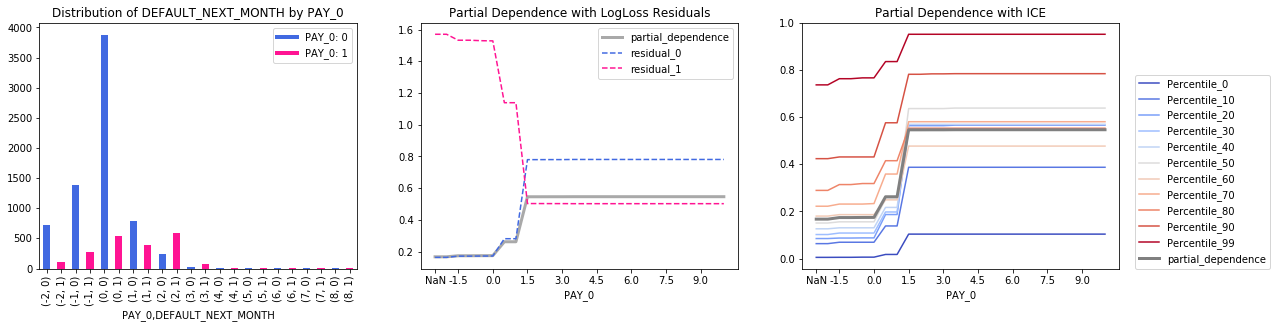

In [18]:
# tricks to have NaN appear on the x-axis
par_dep_PAY_0.iloc[0, 0] = -2.5
ticks = [-2.5] + list(par_dep_PAY_0['PAY_0'])[2:][::3]
labels = ['NaN'] + list(par_dep_PAY_0['PAY_0'])[2:][::3]

# setup 3-way figure
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=False)
plt.tight_layout()
plt.subplots_adjust(left=0.0, right=2.5, wspace=0.2)
   
# histogram grouped by target class for PAY_0 ##################################

from matplotlib.lines import Line2D # custom legend
custom_lines = [Line2D([0], [0], color='royalblue', lw=4),
                Line2D([0], [0], color='deeppink', lw=4)]

# establish groups and plot w/ custome legend
gb = test.groupby(['PAY_0', y]).count()
gb['color'] = 'deeppink'
gb.iloc[::2, :]['color'] = 'royalblue'
_ = test.groupby(['PAY_0', y]).count().plot(kind='bar', y='ID', legend=False, 
                                            color=gb['color'], 
                                            title='Distribution of DEFAULT_NEXT_MONTH by PAY_0', 
                                            ax=ax0)
_ = ax0.legend(custom_lines, ['PAY_0: 0', 'PAY_0: 1'])
 
# partial dependence and residuals #############################################

_ = ax1.set(xticks=ticks, xticklabels=labels)
_ = par_dep_PAY_0.plot(kind='line', x='PAY_0', y='partial_dependence', 
                       color='darkgrey', linewidth=3,
                       title='Partial Dependence with LogLoss Residuals', 
                       ax=ax1)
_ = par_dep_PAY_0.plot(kind='line', x='PAY_0', y='residual_0', color='royalblue', 
                       linestyle='--', ax=ax1)
_ = par_dep_PAY_0.plot(kind='line', x='PAY_0', y='residual_1', color='deeppink', 
                       linestyle='--', ax=ax1)

# partial dependence and ICE ###################################################

plot_par_dep_ICE('PAY_0', par_dep_PAY_0.drop(['residual_0', 'residual_1'], 
                                             axis=1), 
                 ax2, ticks, labels)

These three plots together are highly informative.


* In general there is not much real data for `PAY_0 > 2`, so predictions in that range are low-confidence, no matter what the modeled probability is. Luckily this model was trained with monotonicity constraints and it carries the predictions from `PAY_0 = 2` forward even into out-of-range data. This seems reasonable. However new customers with `PAY_0 > 2` could also be handed over to human case workers or to a more transparent business rule system to be even more cautious.


* This model treats missing data with lower probability of default than someone who paid their most recent bill in-full. This seems worrisome from a predictive accuracy, model drift, and security perspective. Logically, why would `NaN < -2`? Also, `PAY_0` is the most important variable in the model. Setting it to missing would often result in a customer being seen as likely to pay future bills. Is this prediction behavior prudent from a adversarial, drift, or security standpoint? That seems unlikely.


* Partial dependence and ICE curves do not diverge, indicating that partial dependence is trustworthy and representative of local behavior and also that strong interactions with other variables are likley not affecting model predictions w.r.t. `PAY_0`.


* The customer at the 90th percentile of predicted probability of default has the largest observed swing of prediction values across the domain of `PAY_0`.


* The distribution of actual payments and defaults is fairly equal for high values of `PAY_0`, say `PAY_0` > 3, and yet when the scenario in which `PAY_0` is high for everyone is simulated, this leads to both high predicted probabilities and large residuals for `DEFAULT_NEXT_MONTH = 0` individuals. In this case, the inputs to the model changed, but not the labels, so this means that the situation in which someone has paid their bill, but has bad values for `PAY_0`, causes the model to generate high probability of default, and will lead to large errors. *A mechanism for error* has been indentified: `PAY_0 > 2` leads to high error when someone does pay their bill the next month.

# 5. Adversarial Examples

We've learned that the GBM model is highly sensitive to `PAY_0` values by using partial dependence and ICE. But what other variable's values have a large impact on model predictions. In this section we will conduct naive, brute-force searches to find rows of data, known as _adversarial examples_, that exert a strong influence on the trained model. First we will use information learned from Shapley values and ICE to guide a search for rows that can swing model predictions high and low. These rows a particulary interesting from a drift and security viewpoint. If market conditions change so that high-impact values of important features are more common, e.g. a recession, then this search will help us understand potential future model behavior. Combinations of variables with strong effects can also be recorded and then monitored for in real-time as an active preventitive measure against malicious adversarial attacks. Once these rows have been recorded, we will search for combinations of the demographic variables, `AGE`, `SEX`, `MARRIAGE`, and `EDUCATION`, that have a strong effect on model predictions to ellicudate any unforseen fairness problems. Finally we will search for adversarial examples that either minimize model residuals for high-residual customers or that maximize residuals for low-residual customers to in an attempt to isolate or remediate any further error mechanisms.

#### Function to find adversarial examples

In [19]:
def find_adversaries(xs, frame, model, row_id, oor_proportion=0.1, 
                     resolution=10):  
    
    """ A brute force function to find adversaries (rows of data w/ undue 
        influence on model predictions). Dynamically generates nested loops
        to populate adversary_frame with test values and predictions.
        
        ASSUMES global vars `y`, `yhat`, and `resid` have been defined previously.
        
    Args:    
        xs: List of variables over which to find adversaries.
        frame: Pandas DataFrame for which to calculate bounds for adversary search.
               row_id is assumed to be in frame.
        model: Model to use in adversary search.
        row_id: Prototype row on which the search is based.
        oor_proportion: The proportion by which the search can exceed minimum and 
                        maximum values in frame. Must be between 0-1, default 0.1.
        resolution: The number of points across the domain of xs for which 
                    to search for adversaries, default 10 due to deep nesting.
                
    Returns: 
        Frame containing all tested values and their associated predictions. 
    
    """
    
    # init dicts to hold bin values
    bins_dict = {}
    
    # find boundaries, bins and record 
    for j in xs:
        
        min_ = frame[j].min()
        max_ = frame[j].max()
        min_ = min_ - np.abs(oor_proportion*min_)
        max_ = max_ + np.abs(oor_proportion*max_)
        by = (max_ - min_)/resolution
        # modify max and by 
        # to preserve resolution and actually search up to max
        bins_dict[j] = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        bins_dict[j] = np.round_(bins_dict[j], 6)  # reasonable precision
    
    # initialize prototype row
    # deep copy to prevent corruption of original data
    row = frame[frame['ID'] == row_id].copy(deep=True)
    
    # generate nested loops dynamically ############################################
    # to search all vals in all search cols
    
    # init true tab
    # init code variable to contain returned Pandas DataFrame, adversary_frame
    tab = '    '
    code = 'global adversary_frame\n'
    code += 'adversary_frame = pd.DataFrame(columns=xs + [yhat, resid])\n'

    # generate for loop statements for search
    for i, j in enumerate(xs):
        code += i*tab + 'for ' + string.ascii_lowercase[i] + ' in ' +\
            str(list(bins_dict[j])) + ':\n'
            
    # generate value assignment statements to test search values
    for k, j in enumerate(xs):
        code += (i + 1)*tab + 'row["' + j + '"] = ' + string.ascii_lowercase[k] +\
            '\n'
    
    # generate progress reporting statements  
    # generate statements for appending test values and preds to adversary_frame
    code += (i + 1)*tab + 'if adversary_frame.shape[0] % 1000 == 0:\n'
    code += (i + 2)*tab +\
        'print("Built %i/%i rows ..." % (adversary_frame.shape[0], (resolution)**(i+1)))\n'
    code += (i + 1)*tab +\
        'adversary_frame = adversary_frame.append(row, ignore_index=True, sort=False)\n' 
    code += 'print("Scoring ...")\n'
    code += 'adversary_frame[yhat] = model.predict(xgb.DMatrix(adversary_frame[model.feature_names]))\n'
    code += 'adversary_frame[resid] = np.abs(adversary_frame[y]*np.log(adversary_frame[yhat]) - (1 - adversary_frame[y])*np.log(1 - adversary_frame[yhat]))\n'
    code += 'print("Done.")'

    # execute generated code
    print('Executing:')
    print(code)
    print('--------------------------------------------------------------------------------')
    exec(code)
    
    return adversary_frame


#### Conduct adversarial example search over important variables for an interesting row
From the ICE plot in section 4, we can see that the customer at the 90th percentile of predicted probability of default has a high degree of variabliltiy in their predictions across the values of `PAY_0`. From the Shapley summary plot in section 3, we can see that `PAY_0`, `PAY_3`, `PAY_AMT1`, and `PAY_AMT2`, exhibit the most extreme local prediction contributions. We will use the customer at the 90th percentile of probability of default as a prototype row and then search over 10,000 permutations of `PAY_0`, `PAY_3`, `PAY_AMT1`, and `PAY_AMT2` to find adversarial examples with the largest impact on model predictions and to understand the contributions and interactions of these variables in the model in general.

In [20]:
res_ = 10 # keep resolution small to avoid long run time

# four variables with widest Shapley contribs
search_cols = ['PAY_0', 'PAY_3', 'PAY_AMT1', 'PAY_AMT2'] 

# execute search
pred_adversaries = find_adversaries(search_cols, test, xgb_model, pred_percentile_dict[90], resolution=res_)

Executing:
global adversary_frame
adversary_frame = pd.DataFrame(columns=xs + [yhat, resid])
for a in [-2.2, -0.99, 0.22, 1.43, 2.64, 3.85, 5.06, 6.27, 7.48, 8.69]:
    for b in [-2.2, -0.99, 0.22, 1.43, 2.64, 3.85, 5.06, 6.27, 7.48, 8.69]:
        for c in [0.0, 105699.792, 211399.584, 317099.376, 422799.168, 528498.96, 634198.752, 739898.544, 845598.336, 951298.128]:
            for d in [0.0, 147071.991, 294143.982, 441215.973, 588287.964, 735359.955, 882431.946, 1029503.937, 1176575.928, 1323647.919]:
                row["PAY_0"] = a
                row["PAY_3"] = b
                row["PAY_AMT1"] = c
                row["PAY_AMT2"] = d
                if adversary_frame.shape[0] % 1000 == 0:
                    print("Built %i/%i rows ..." % (adversary_frame.shape[0], (resolution)**(i+1)))
                adversary_frame = adversary_frame.append(row, ignore_index=True, sort=False)
print("Scoring ...")
adversary_frame[yhat] = model.predict(xgb.DMatrix(adversary_frame[model.feature_

#### The original row, used as prototype 

In [21]:
test[test['ID'] == pred_percentile_dict[90]]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
6667,6668,50000,1,2,2,39,1,2,2,2,2,2,39966,37584,38423,37212,39319,36082,0,3000,0,3007,7,3119,0


#### The prototype row's original target label and prediction

In [22]:
row_y = test[test['ID'] == pred_percentile_dict[90]][y].values[0]
row_yhat = xgb_model.predict(xgb.DMatrix(test[test['ID'] == pred_percentile_dict[90]][xgb_model.feature_names]))[0]
print('Original Target: ', row_y)
print('Original Prediction', row_yhat)

Original Target:  0
Original Prediction 0.5758703


#### Adversarial examples that minimize model predictions
These, and similar, rows minimize the predicted probability of default for the prototype row. They could be used by a malicious attacker in a falsified application to maximize their chance at receiving underserved credit line increases, loans, or other financially beneficial outcomes. These rows should be recorded and monitored after the model is deployed.

In [23]:
pred_adversaries.sort_values(by=yhat).head(n=3)

,PAY_0,PAY_3,PAY_AMT1,PAY_AMT2,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
183,-2.2,-0.99,845598.336,441215.973,0.155915,0.169502,6668.0,50000.0,1.0,2.0,2.0,39.0,2.0,2.0,2.0,2.0,39966.0,37584.0,38423.0,37212.0,39319.0,36082.0,0.0,3007.0,7.0,3119.0,0.0
129,-2.2,-0.99,211399.584,1323647.919,0.155915,0.169502,6668.0,50000.0,1.0,2.0,2.0,39.0,2.0,2.0,2.0,2.0,39966.0,37584.0,38423.0,37212.0,39319.0,36082.0,0.0,3007.0,7.0,3119.0,0.0
131,-2.2,-0.99,317099.376,147071.991,0.155915,0.169502,6668.0,50000.0,1.0,2.0,2.0,39.0,2.0,2.0,2.0,2.0,39966.0,37584.0,38423.0,37212.0,39319.0,36082.0,0.0,3007.0,7.0,3119.0,0.0


#### Adversarial examples that maximize model preditions
These, and similar, rows maximize the predicted probability of default for the prototype row. They could be used by a malicious attacker in a hacked, falsified application to minimize another customer's chances of receiving credit line increases, loans, or other financially beneficial outcomes. These rows should be recorded and monitored after the model is deployed.

In [24]:
pred_adversaries.sort_values(by=yhat).tail(n=3)

,PAY_0,PAY_3,PAY_AMT1,PAY_AMT2,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
8900,7.48,8.69,0.0,0.0,0.787195,1.547377,6668.0,50000.0,1.0,2.0,2.0,39.0,2.0,2.0,2.0,2.0,39966.0,37584.0,38423.0,37212.0,39319.0,36082.0,0.0,3007.0,7.0,3119.0,0.0
5900,3.85,8.69,0.0,0.0,0.787195,1.547377,6668.0,50000.0,1.0,2.0,2.0,39.0,2.0,2.0,2.0,2.0,39966.0,37584.0,38423.0,37212.0,39319.0,36082.0,0.0,3007.0,7.0,3119.0,0.0
9800,8.69,7.48,0.0,0.0,0.787195,1.547377,6668.0,50000.0,1.0,2.0,2.0,39.0,2.0,2.0,2.0,2.0,39966.0,37584.0,38423.0,37212.0,39319.0,36082.0,0.0,3007.0,7.0,3119.0,0.0


#### Function to plot small multiples display as visual summary of search results.

In [25]:
def plot_sm_3d(frame, resolution, search_cols, z_axis_var, stat):

    fig = plt.figure(figsize=plt.figaspect(0.67)*2.5) # init 2 x 3 plot

    _2d_shape = (resolution, resolution) # correct shape for 3-D display of 1-D arrays

    # loop through 2-way combos of search_cols
    for i, two_way_combo in enumerate(list(combinations(search_cols, 2))):

        # many unique values exist for each 2-way combos of search_col values 
        # summarize by mean to plot concisely
        
        groups = eval('frame[[two_way_combo[0], two_way_combo[1], z_axis_var]]\
                        .groupby([two_way_combo[0], two_way_combo[1]]).' + stat + '()')

        groups = groups.reset_index() # convert groupby vals to cols (from index)

        ax = fig.add_subplot(2, 3, (i + 1), projection='3d') # subplot placement
            
        # values and labels for each axis
        x = np.asarray(groups[two_way_combo[0]]).reshape(_2d_shape)
        ax.set_xlabel('\n' + two_way_combo[0])
        y = np.asarray(groups[two_way_combo[1]]).reshape(_2d_shape)
        ax.set_ylabel('\n' + two_way_combo[1])
        z = np.asarray(groups[z_axis_var]).reshape(_2d_shape)
        ax.set_zlabel('\nMean ' + str(z_axis_var))

        # plot
        surf = ax.plot_surface(x, y, z, 
                               cmap=cm.coolwarm, 
                               linewidth=0.05, 
                               rstride=1, 
                               cstride=1, 
                               antialiased=True)
        
    
    # main title and display    
    fig.suptitle(stat.title() + ' ' + str(z_axis_var) + ' for ' + str(search_cols))    
    plt.tight_layout()
    _ = plt.show()
    

#### Plot of Average Predictions Across Pairs of Search Columns

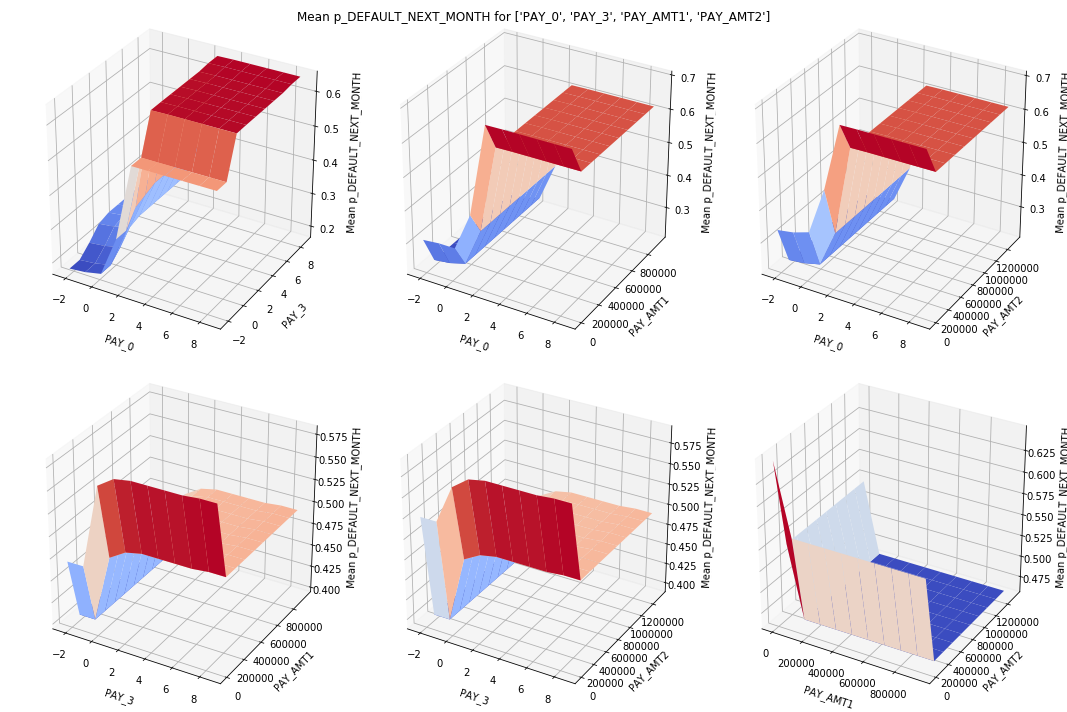

In [26]:
plot_sm_3d(pred_adversaries, res_, search_cols, yhat, 'mean')

The search has revealed several interesting patterns: 

* Monotonicity was preserved across this set of averaged interactions.


* There appear to be some interactions between all of `PAY_0`, `PAY_3`, `PAY_AMT1`, and `PAY_AMT2`, which may not be observed in the training or validation data. If these interactions are unrealistic, but having a strong effect on the model, they should be remediated from the model by some method.


* Obvious combinations of values for `PAY_0` and `PAY_3` lead to extreme predicted probabilities of default, but so do combinations of the repayment status and payment amount variables. Perhaps more surprisingly, combinations of the payment amount variables alone can also lead to extreme predictions. These payment amount value combinations could be the more subtle route for an adversarial attack. 


* While these results appear logical and reasurring from a model accuracy standpoint (aside from the over-emphasis on `PAY_0`), it does reveal that the model is vulnerable to adversarial attack. Active counter-measures should be considered.


* Users should investigate these patterns to get a sense for how their model might perform if data drifts in any of the searched directions.

#### Can we find adversaries that help us learn about error mechanisms? Stay tuned ...  

* Perfectly inversely correlated with predictions for a single row
* Add residual to function above
* Take high error point and search to reduce it's residual
* Take low error point and search to increase it's residual
* Unrealistic, but strong effects should be remediated from model

In [27]:
resid_percentile_dict = get_percentile_dict(resid, 'ID', yhat_test)

In [28]:
high_row = yhat_test[yhat_test['ID'] == resid_percentile_dict[99]]
high_row

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
300,983,500000,1,1,2,36,-2,-2,-2,-2,-2,-2,45106,81264,18122,27229,21462,27911,81690,18225,27365,21570,28050,17397,1,0.007341,4.914304


In [29]:
high_resid_adversaries = find_adversaries(search_cols, test, xgb_model, resid_percentile_dict[99], resolution=res_)

Executing:
global adversary_frame
adversary_frame = pd.DataFrame(columns=xs + [yhat, resid])
for a in [-2.2, -0.99, 0.22, 1.43, 2.64, 3.85, 5.06, 6.27, 7.48, 8.69]:
    for b in [-2.2, -0.99, 0.22, 1.43, 2.64, 3.85, 5.06, 6.27, 7.48, 8.69]:
        for c in [0.0, 105699.792, 211399.584, 317099.376, 422799.168, 528498.96, 634198.752, 739898.544, 845598.336, 951298.128]:
            for d in [0.0, 147071.991, 294143.982, 441215.973, 588287.964, 735359.955, 882431.946, 1029503.937, 1176575.928, 1323647.919]:
                row["PAY_0"] = a
                row["PAY_3"] = b
                row["PAY_AMT1"] = c
                row["PAY_AMT2"] = d
                if adversary_frame.shape[0] % 1000 == 0:
                    print("Built %i/%i rows ..." % (adversary_frame.shape[0], (resolution)**(i+1)))
                adversary_frame = adversary_frame.append(row, ignore_index=True, sort=False)
print("Scoring ...")
adversary_frame[yhat] = model.predict(xgb.DMatrix(adversary_frame[model.feature_

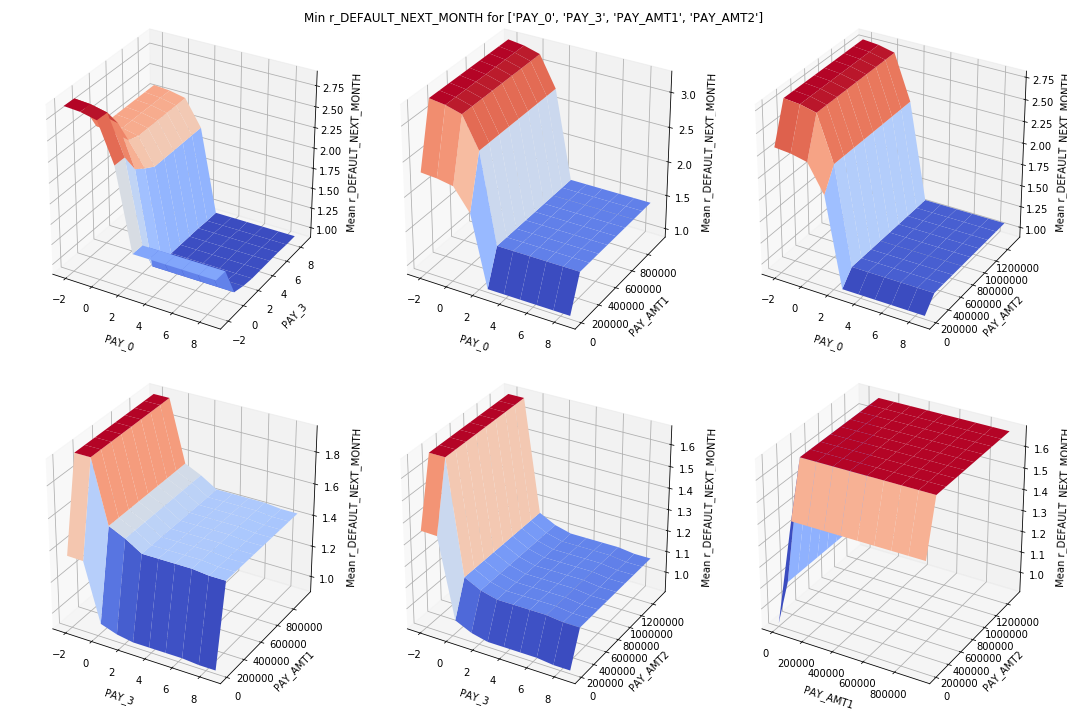

In [30]:
plot_sm_3d(high_resid_adversaries, res_, search_cols, resid, 'min')

#### Can we find adversaries that lead to undesirable outcomes for `AGE`, `EDUCATION`, `SEX` and `MARRIAGE`? Stay tuned ...  Not really
* Same search as above, just on different features
* Unrealistic, but strong effects should be remediated from model

Executing:
global adversary_frame
adversary_frame = pd.DataFrame(columns=xs + [yhat, resid])
for a in [18.9, 25.896, 32.892, 39.888, 46.884, 53.88, 60.876, 67.872, 74.868, 81.864]:
    for b in [0.0, 0.726, 1.452, 2.178, 2.904, 3.63, 4.356, 5.082, 5.808, 6.534]:
        for c in [0.9, 1.043, 1.186, 1.329, 1.472, 1.615, 1.758, 1.901, 2.044, 2.187]:
            for d in [0.0, 0.363, 0.726, 1.089, 1.452, 1.815, 2.178, 2.541, 2.904, 3.267]:
                row["AGE"] = a
                row["EDUCATION"] = b
                row["SEX"] = c
                row["MARRIAGE"] = d
                if adversary_frame.shape[0] % 1000 == 0:
                    print("Built %i/%i rows ..." % (adversary_frame.shape[0], (resolution)**(i+1)))
                adversary_frame = adversary_frame.append(row, ignore_index=True, sort=False)
print("Scoring ...")
adversary_frame[yhat] = model.predict(xgb.DMatrix(adversary_frame[model.feature_names]))
adversary_frame[resid] = np.abs(adversary_frame[y]*np.log(advers

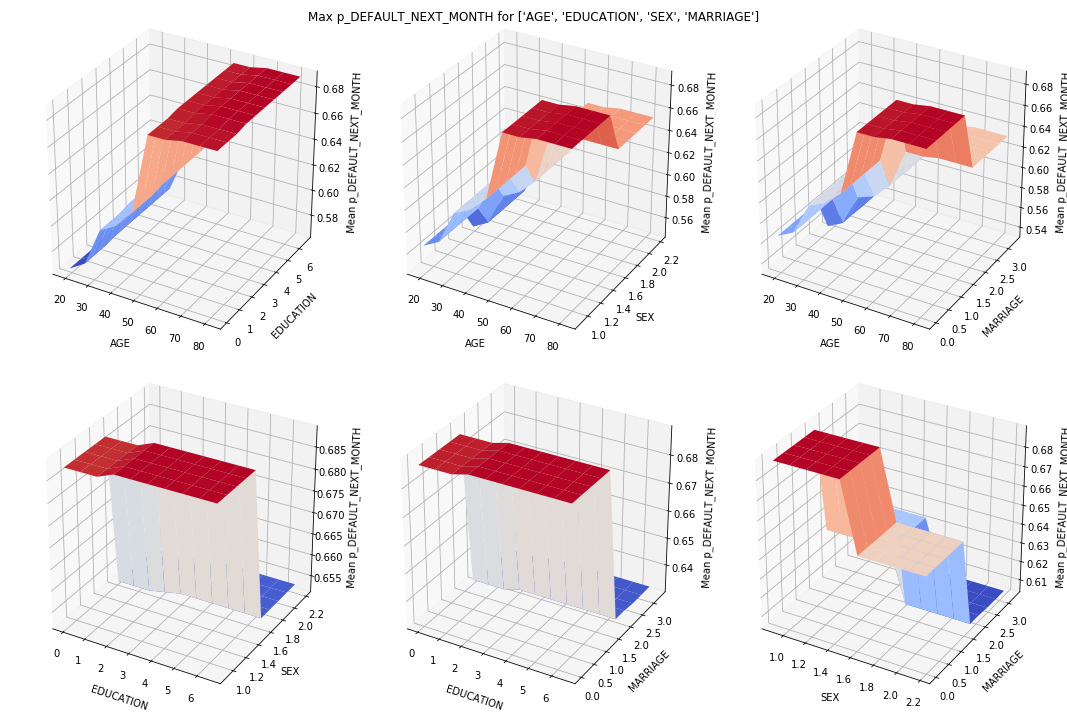

In [31]:
search_cols = ['AGE', 'EDUCATION', 'SEX', 'MARRIAGE'] 

# execute search
dem_adversaries = find_adversaries(search_cols, test, xgb_model, pred_percentile_dict[90], resolution=res_)

plot_sm_3d(dem_adversaries, res_, search_cols, yhat, 'max')

# 6. Bonus: Random Attacks
Random attacks expose a model to random data in an attempt to discover patterns or problems structured or guided searches may not reveal. As the nonlinear or interaction complexity of machine learning models may simply be incomprehensible to human users in some cases, exposure to random data may help reveal unforseen, unaccounted for, or previously unknown problems. 

#### Function for random attacks

In [32]:
def random_attack(X, frame, model, oor_proportion=0.33, N=10000, 
                  inject_missing=True, missing_proportion=0.15, seed=12345):

    """ Generates random data and scores model on random data.

    Args:
        X: Input variables for model in frame.
        frame: Pandas DataFrame for which to calculate bounds 
               for random data.
        model: Model to score on random data.
        oor_proportion: The proportion by which the random values can 
                        exceed minimum and maximum values in frame. 
                        Must be between 0-1, default 0.33.
        N: Number of random samples to generate.
        inject_missing: Whether to randomly inject missing values into 
                        generated frame.
        missing_proportion: The proportion of random values to be  
                            replaced by nan. Must be between 0-1, 
                            default 0.15.
        seed: Seed to enforce reproducibility. 

    Returns:
        Scored random frame.

    """
    
    # init random frame
    random_frame = pd.DataFrame(columns=X, index=np.arange(N))
    
    # find bounds for each j and generate random data
    for j in X:
        
        min_ = frame[j].min()
        max_ = frame[j].max()
        
        np.random.seed(seed) # ensure columns are set similary 
        random_frame[j] =\
            np.random.uniform(low=(min_ - np.abs(oor_proportion*min_)),
                              high=(max_ + np.abs(oor_proportion*max_)),
                              size=(N,)) 
        
        # ensure treatment as numeric
        random_frame[j] = pd.to_numeric(random_frame[j])
        
    if inject_missing:
        
        np.random.seed(seed) # ensure nan is injected similarly       
        random_frame =\
            random_frame.mask(np.random.random(random_frame.shape) < missing_proportion)    
    
    # score
    random_frame[yhat] = model.predict(xgb.DMatrix(random_frame[model.feature_names]))

    return random_frame



#### Execute random attacks with and without missing values
Partial dependence and ICE revealed a potentially worrisome correlation between low predicted probabilities and missing values. We will examine that relationship here as well as look for problems we had not considered earlier.

In [33]:
# Run largish random attack
N_ = 1000000
randoms_w_miss = random_attack(X, test, xgb_model, N=N_)
randoms_wo_miss = random_attack(X, test, xgb_model, N=N_, inject_missing=False)

#### Confirm the only difference between the two random attacks is the presence of missing values

In [34]:
randoms_w_miss.head(n=5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
0,1.236861e+06,2.519936,7.418336,3.709168,93.719507,9.703894,9.703894,9.703894,9.703894,9.703894,9.703894,1.178004e+06,NaN,NaN,1.101620e+06,1.140599e+06,1.174860e+06,1.080050e+06,1.502795e+06,1.107854e+06,767797.819540,383447.627638,651754.019301,0.690121
1,4.253598e+05,1.299587,2.524677,1.262338,41.177058,1.547795,1.547795,NaN,1.547795,1.547795,NaN,2.649418e+05,352621.957687,234265.111327,NaN,3.343339e+05,2.673989e+05,3.675728e+05,5.114453e+05,3.770353e+05,NaN,130498.446385,221810.961429,0.368588
2,2.500798e+05,1.035998,1.467672,0.733836,29.828164,-0.213880,-0.213880,-0.213880,-0.213880,-0.213880,-0.213880,6.772515e+04,167389.440220,101937.093858,2.096570e+05,1.601847e+05,7.139200e+04,2.136813e+05,NaN,2.191822e+05,151904.064128,75862.748677,128945.513811,0.052521
3,2.773946e+05,1.077075,1.632391,0.816196,31.596725,0.060652,0.060652,0.060652,0.060652,0.060652,0.060652,9.845852e+04,196255.247953,122558.500738,2.343472e+05,1.873234e+05,1.019368e+05,2.376631e+05,3.306873e+05,2.437813e+05,168952.470865,84376.931645,143417.250160,0.027404
4,7.579705e+05,1.799773,NaN,2.265223,62.712680,4.890743,4.890743,NaN,4.890743,4.890743,4.890743,NaN,NaN,485370.316867,6.687453e+05,6.647986e+05,6.393410e+05,6.595967e+05,9.177709e+05,6.765768e+05,468901.133269,234174.964519,NaN,0.648329


In [35]:
randoms_wo_miss.head(n=5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
0,1.236861e+06,2.519936,7.418336,3.709168,93.719507,9.703894,9.703894,9.703894,9.703894,9.703894,9.703894,1.178004e+06,1.210201e+06,846909.684010,1.101620e+06,1.140599e+06,1.174860e+06,1.080050e+06,1.502795e+06,1.107854e+06,767797.819540,383447.627638,651754.019301,0.598351
1,4.253598e+05,1.299587,2.524677,1.262338,41.177058,1.547795,1.547795,1.547795,1.547795,1.547795,1.547795,2.649418e+05,3.526220e+05,234265.111327,3.680946e+05,3.343339e+05,2.673989e+05,3.675728e+05,5.114453e+05,3.770353e+05,261304.061796,130498.446385,221810.961429,0.569137
2,2.500798e+05,1.035998,1.467672,0.733836,29.828164,-0.213880,-0.213880,-0.213880,-0.213880,-0.213880,-0.213880,6.772515e+04,1.673894e+05,101937.093858,2.096570e+05,1.601847e+05,7.139200e+04,2.136813e+05,2.973188e+05,2.191822e+05,151904.064128,75862.748677,128945.513811,0.022089
3,2.773946e+05,1.077075,1.632391,0.816196,31.596725,0.060652,0.060652,0.060652,0.060652,0.060652,0.060652,9.845852e+04,1.962552e+05,122558.500738,2.343472e+05,1.873234e+05,1.019368e+05,2.376631e+05,3.306873e+05,2.437813e+05,168952.470865,84376.931645,143417.250160,0.027404
4,7.579705e+05,1.799773,4.530446,2.265223,62.712680,4.890743,4.890743,4.890743,4.890743,4.890743,4.890743,6.391795e+05,7.041186e+05,485370.316867,6.687453e+05,6.647986e+05,6.393410e+05,6.595967e+05,9.177709e+05,6.765768e+05,468901.133269,234174.964519,398032.125757,0.586146


#### Plot ranked predictions with a reference line

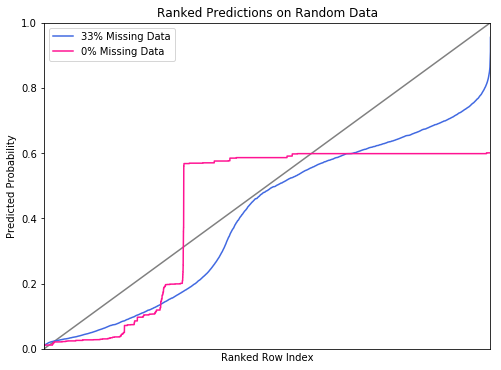

In [36]:
fig, ax = plt.subplots(figsize=(8, 6)) # init plot

# 45-degree reference line
_ = ax.plot(np.linspace(*[0, N_]), np.linspace(*[0, 1]), c='grey', linestyle='-')

# sorted preds w/ missing
_ = randoms_w_miss.sort_values(by=yhat).reset_index().plot(y=yhat, ax=ax,
                                                           title='Ranked Predictions on Random Data',
                                                           color='royalblue',
                                                           label='33% Missing Data')

# sorted preds w/o missing
_ = randoms_wo_miss.sort_values(by=yhat).reset_index().plot(y=yhat, ax=ax,
                                                            label='0% Missing Data',
                                                            color='deeppink')
# margins and axes decoration
_ = ax.margins(x=0, y=0) 
_ = ax.get_xaxis().set_ticks([])
_ = ax.set_xlabel('Ranked Row Index')
_ = ax.set_ylabel('Predicted Probability')

These results confirm the model treats customers with missing data quite differently than those without missing data. Missing values appear to increase output probabilites for low and high predicted probabilities, but seem to decrease model output for medium range predictions relative to rows without missing data. If missing data were to be allowed in credit applications, or could be hacked into the process, missingness could be used in an adversarial attack to alter the model's predictions. Also, if missingness was to somehow become more common in future data, that would have a notable impact on future model predictions. 

Aside from general observations regarding missing values, the adversarial examples of interest seem to be on the extreme low side for both missing and non-missing cases, in the middle range of model output for rows without missing data, and the in the extreme high range of rows with missing data. Let's have a quick look below.

#### Low-range non-missing random adversarial examples

In [37]:
randoms_wo_miss.sort_values(by=yhat).head(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
441922,206229.540940,0.970056,1.203239,0.601619,26.988984,-0.654602,-0.654602,-0.654602,-0.654602,-0.654602,-0.654602,18386.983869,121049.374329,68832.274399,170020.294494,116617.434677,22356.477208,175181.924959,243750.285629,179691.663507,124535.202712,62194.404337,105713.140682,0.011461
252727,209347.438011,0.974745,1.222041,0.611020,27.190859,-0.623265,-0.623265,-0.623265,-0.623265,-0.623265,-0.623265,21895.092179,124344.307565,71186.137472,172838.597634,119715.215362,25843.066514,177919.360268,247559.186797,182499.569087,126481.220038,63166.269205,107365.039895,0.011461
849829,205113.942827,0.968378,1.196511,0.598256,26.916752,-0.665815,-0.665815,-0.665815,-0.665815,-0.665815,-0.665815,17131.766355,119870.431849,67990.051213,169011.892486,115509.034300,21108.959292,174202.457838,242387.443027,178686.981795,123838.908637,61846.666554,105122.083439,0.011461


#### Low-range random adversarial examples with missingness

In [38]:
randoms_w_miss.sort_values(by=yhat).head(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
35709,2.614165e+05,1.053047,NaN,0.768018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80480.679620,1.793699e+05,110495.770679,219904.403622,171448.310580,84069.285506,223634.669358,3.111680e+05,229391.735273,158979.808496,79396.462009,134951.840886,0.008533
260613,1.072209e+06,2.272329,NaN,3.212710,83.058729,NaN,NaN,NaN,NaN,NaN,NaN,992745.218968,1.036199e+06,722605.096464,952788.850009,977009.376679,990737.924786,935489.874860,1.301652e+06,959572.352269,665031.059729,332124.650095,564519.272011,0.008641
60360,2.210730e+05,0.992378,1.292751,0.646375,NaN,NaN,-0.505416,-0.505416,-0.505416,NaN,NaN,35088.186785,1.367357e+05,80038.412110,183437.512115,131365.173130,38955.233674,188214.151600,2.618835e+05,193059.381010,133799.691540,66821.203439,113577.408691,0.008671


#### Mid-range non-missing random adversarial examples

In [39]:
randoms_wo_miss[(randoms_wo_miss[yhat] > 0.3) & (randoms_wo_miss[yhat] < 0.5)].sort_values(by=yhat).head(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
397455,8002.071129,0.671958,0.007852,0.003926,14.154305,-2.646913,-2.646913,-2.646913,-2.646913,-2.646913,-2.646913,-204649.061988,-88433.576450,-80819.978612,-9159.802882,-80331.089715,-199311.448581,1143.185744,1590.642709,1172.614972,812.680123,405.862399,689.852880,0.301302
36301,7990.809235,0.671941,0.007784,0.003892,14.153576,-2.647027,-2.647027,-2.647027,-2.647027,-2.647027,-2.647027,-204661.733331,-88445.477801,-80828.480802,-9169.982637,-80342.278947,-199324.042197,1133.298085,1576.884898,1162.472773,805.651078,402.352008,683.886194,0.301302
240740,7998.695699,0.671953,0.007832,0.003916,14.154087,-2.646947,-2.646947,-2.646947,-2.646947,-2.646947,-2.646947,-204652.859860,-88437.143539,-80822.526900,-9162.853972,-80334.443367,-199315.223157,1140.222201,1586.519199,1169.575138,810.573368,404.810260,688.064536,0.301302


In [40]:
randoms_wo_miss[(randoms_wo_miss[yhat] > 0.3) & (randoms_wo_miss[yhat] < 0.5)].sort_values(by=yhat).tail(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
172011,6702.080235,0.670003,0.000013,6.272303e-06,14.070135,-2.659979,-2.659979,-2.659979,-2.659979,-2.659979,-2.659979,-206111.749419,-89807.381648,-81801.409522,-10334.879651,-81622.693186,-200765.163776,1.826394,2.541267,1.873411,1.298367,0.648420,1.102134,0.408756
321977,6701.683867,0.670003,0.000010,5.077178e-06,14.070109,-2.659983,-2.659983,-2.659983,-2.659983,-2.659983,-2.659983,-206112.195393,-89807.800522,-81801.708761,-10335.237933,-81623.086997,-200765.607015,1.478393,2.057054,1.516452,1.050976,0.524870,0.892133,0.410410
219634,6700.318812,0.670000,0.000002,9.612794e-07,14.070021,-2.659997,-2.659997,-2.659997,-2.659997,-2.659997,-2.659997,-206113.731288,-89809.243085,-81802.739312,-10336.471822,-81624.443245,-200767.133488,0.279909,0.389469,0.287115,0.198985,0.099375,0.168911,0.412544


#### High-range random adversarial examples with missingness

In [41]:
randoms_w_miss.sort_values(by=yhat).tail(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,p_DEFAULT_NEXT_MONTH
837153,607685.259629,NaN,3.624169,1.812084,52.982127,3.380281,3.380281,3.380281,3.380281,3.380281,3.380281,NaN,NaN,371912.129290,532900.751148,515482.997959,NaN,NaN,NaN,NaN,NaN,NaN,318409.188931,0.951279
868139,NaN,2.252173,6.344592,NaN,82.190878,7.914319,7.914319,7.914319,NaN,7.914319,7.914319,NaN,1.022035e+06,712485.960481,NaN,NaN,NaN,NaN,NaN,947501.310963,656665.231584,327946.653136,557417.842468,0.952012
788002,NaN,2.198091,6.127723,NaN,79.862400,7.552872,7.552872,7.552872,7.552872,7.552872,7.552872,NaN,9.840300e+05,685335.915281,908166.097066,NaN,NaN,NaN,NaN,915114.225976,634219.381201,316736.920755,NaN,0.954732


Any of the above values could be used in an adversarial attack and should potentially be monitored for after the model is deployed. These values could also be used to find non-sensical, non-robust interactions that can cause unwanted model behavior. If these interactions can be isolated, they can be potentially remediated from model mechanisms.

#### Conclusion
Now that we can indentify global and local error mechanisms, can we:  
* Study the error mechanisms and make manual changes to address them? 
* Study fairness problems and make manual changes to address them?
* Understand what feature values are associated with low and high residuals and use this information to improve model performance.
* Record possible security threats and monitor for them?
* Assess model drift scenarios?
* Find non-robust interactions with strong relationships to the target and remediate them from model mechanisms?